In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

import joblib

import os

In [15]:
def generate_synthetic_property_data(n_samples=200):
    # Generate features with appropriate data types
    luas_tanah = np.random.uniform(50, 500, n_samples)
    luas_bangunan = np.random.uniform(30, 400, n_samples)
    # Ensure building area doesn't exceed land area
    luas_bangunan = np.minimum(luas_bangunan, luas_tanah)
    
    # INTEGER VALUES (no decimals)
    jumlah_kamar = np.random.randint(1, 6, n_samples)  # 1-5 bedrooms
    umur_bangunan = np.random.randint(0, 31, n_samples)  # 0-30 years
    
    jarak_kota = np.random.uniform(1, 20, n_samples)
    
    # Create base price with non-linear relationships
    base_price = (
        luas_tanah * 2.5 +                    # Land value
        luas_bangunan * 8 +                   # Building value
        jumlah_kamar * 150 +                  # Bedroom premium
        (30 - umur_bangunan) * 25 +           # Age depreciation
        (20 - jarak_kota) * 80 +              # Distance penalty
        luas_tanah * jumlah_kamar * 0.5 +     # Interaction term
        np.sqrt(luas_bangunan) * 50           # Non-linear term
    )
    
    # Add some noise and ensure realistic range
    noise = np.random.normal(0, 200, n_samples)
    harga_properti = base_price + noise
    
    # Ensure price stays within realistic bounds (200-5000)
    harga_properti = np.clip(harga_properti, 200, 5000)
    
    # PROPER DATA TYPE HANDLING:
    # Round to 2 decimal places for continuous variables
    luas_tanah = np.round(luas_tanah, 2)
    luas_bangunan = np.round(luas_bangunan, 2)
    jarak_kota = np.round(jarak_kota, 2)
    harga_properti = np.round(harga_properti, 2)
    
    # Create DataFrame
    data = pd.DataFrame({
        'Luas_Tanah': luas_tanah,
        'Luas_Bangunan': luas_bangunan,
        'Jumlah_Kamar_Tidur': jumlah_kamar,      # INTEGER
        'Umur_Bangunan': umur_bangunan,          # INTEGER
        'Jarak_ke_Pusat_Kota': jarak_kota,
        'Harga_Properti': harga_properti
    })
    
    return data

In [16]:
df = generate_synthetic_property_data(250)
print(f"Dataset generated with {len(df)} samples")

df.head()

Dataset generated with 250 samples


,Luas_Tanah,Luas_Bangunan,Jumlah_Kamar_Tidur,Umur_Bangunan,Jarak_ke_Pusat_Kota,Harga_Properti
0,218.54,138.95,1,0,15.01,3852.44
1,477.82,172.49,1,5,9.59,5000.00
2,379.40,344.92,1,17,5.27,5000.00
3,319.40,147.26,5,23,9.60,5000.00
4,120.21,92.71,4,9,3.68,3970.43


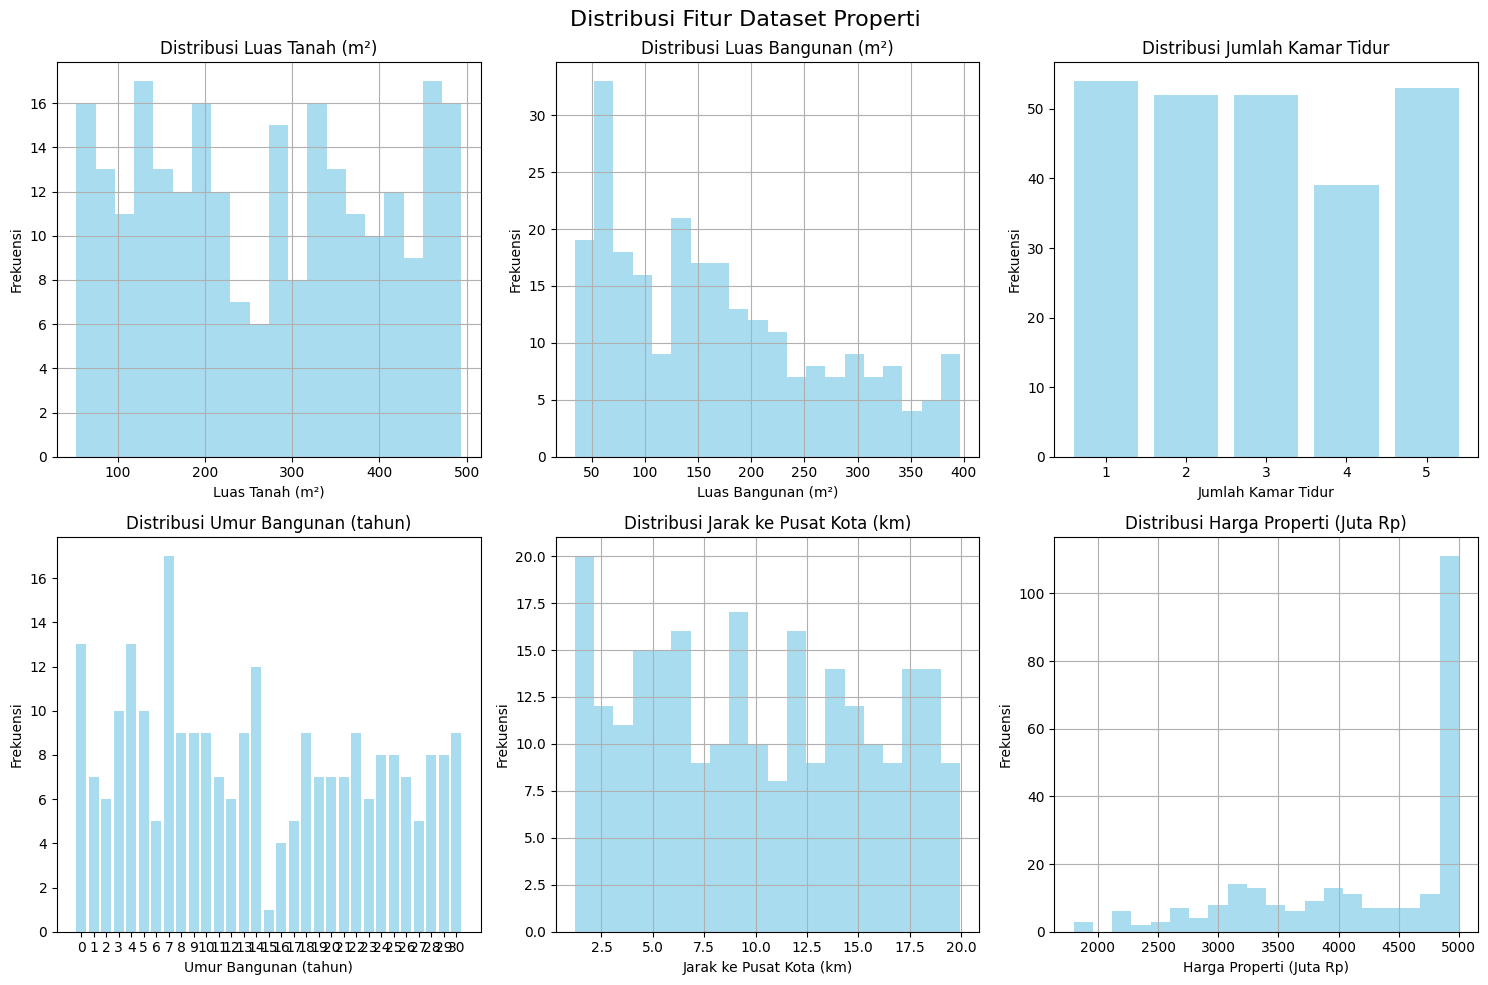

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribusi Fitur Dataset Properti', fontsize=16)

features = ['Luas_Tanah', 'Luas_Bangunan', 'Jumlah_Kamar_Tidur', 
            'Umur_Bangunan', 'Jarak_ke_Pusat_Kota', 'Harga_Properti']
titles = ['Luas Tanah (m²)', 'Luas Bangunan (m²)', 'Jumlah Kamar Tidur',
          'Umur Bangunan (tahun)', 'Jarak ke Pusat Kota (km)', 'Harga Properti (Juta Rp)']

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[i//3, i%3]
    
    # Use bar plot for discrete integer data, histogram for continuous
    if feature in ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']:
        value_counts = df[feature].value_counts().sort_index()
        ax.bar(value_counts.index, value_counts.values, alpha=0.7, color='skyblue')
        ax.set_xticks(value_counts.index)
    else:
        df[feature].hist(bins=20, ax=ax, alpha=0.7, color='skyblue')
    
    ax.set_title(f'Distribusi {title}')
    ax.set_xlabel(title)
    ax.set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

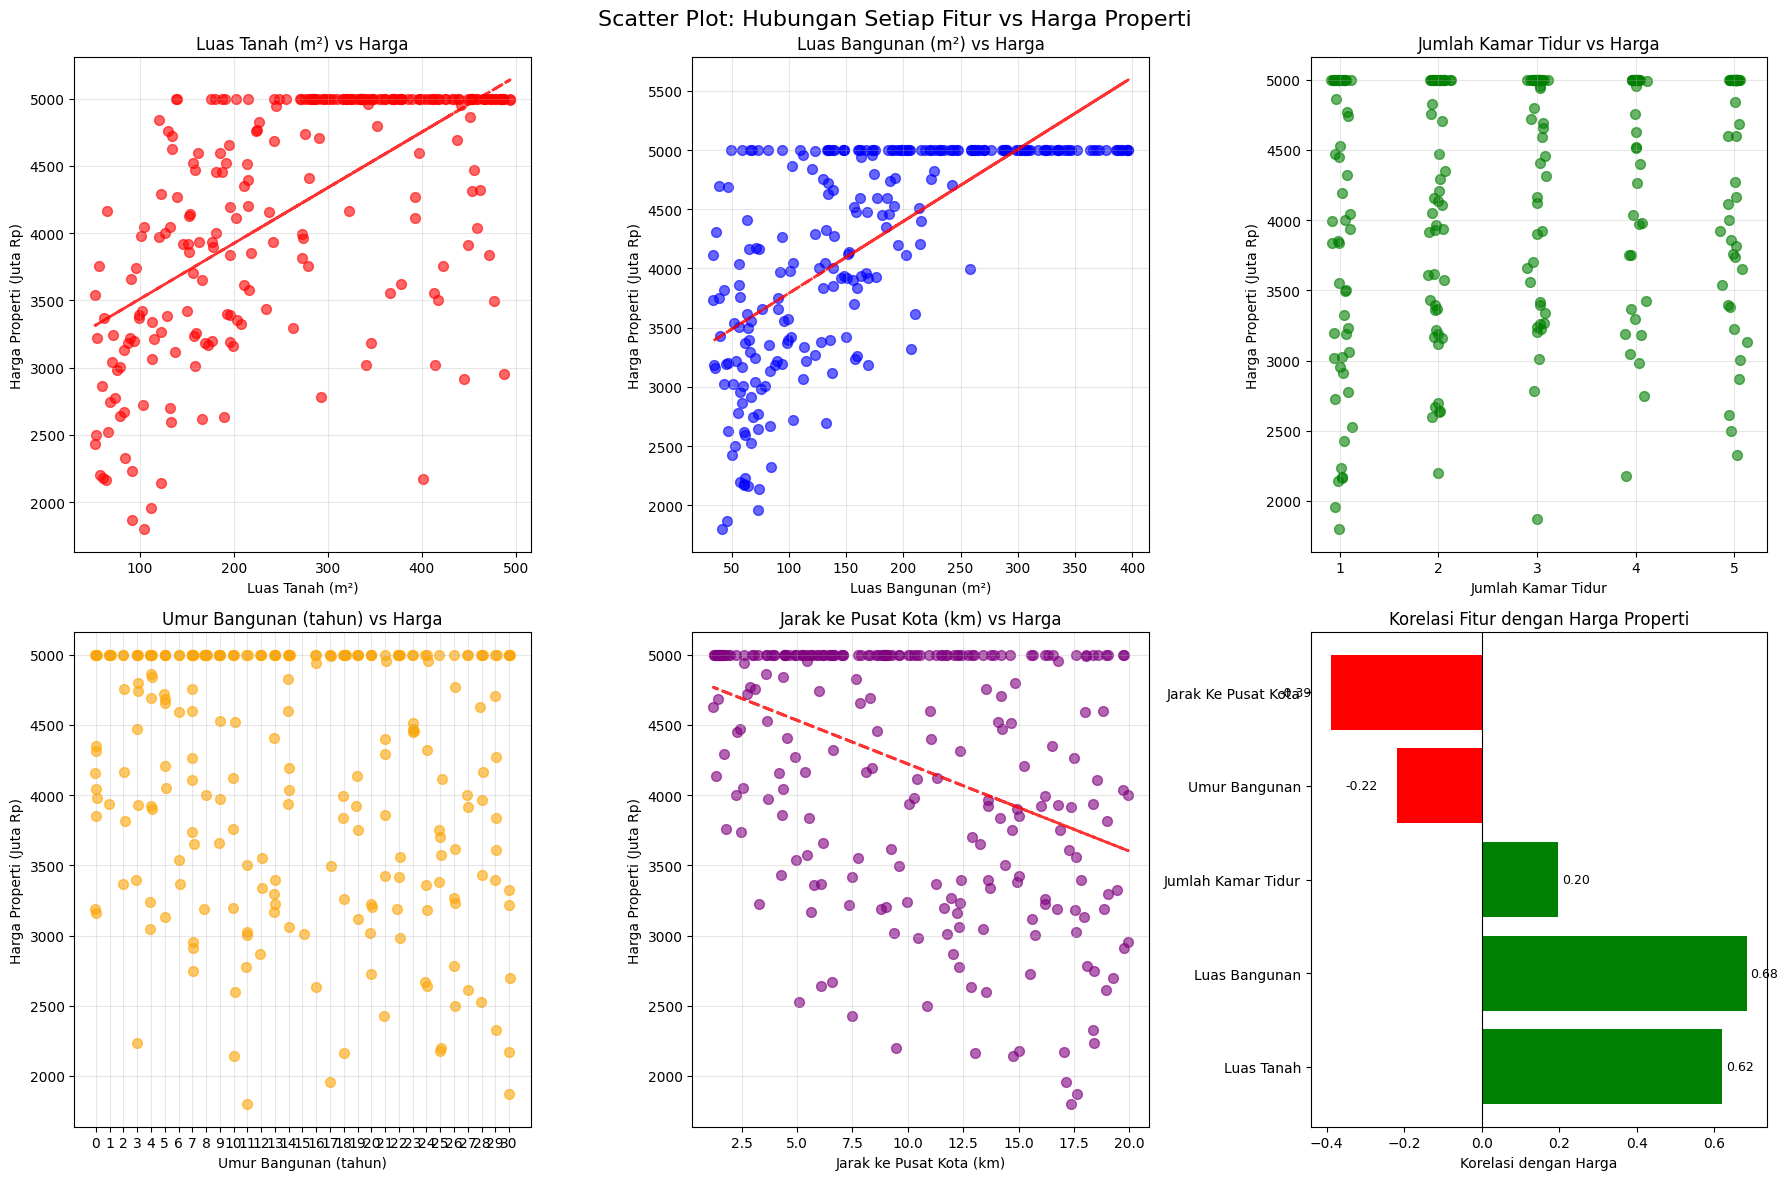

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Scatter Plot: Hubungan Setiap Fitur vs Harga Properti', fontsize=16)

# Warna berbeda untuk setiap fitur
colors = ['red', 'blue', 'green', 'orange', 'purple']
feature_names = ['Luas_Tanah', 'Luas_Bangunan', 'Jumlah_Kamar_Tidur', 
                'Umur_Bangunan', 'Jarak_ke_Pusat_Kota']
feature_titles = ['Luas Tanah (m²)', 'Luas Bangunan (m²)', 'Jumlah Kamar Tidur',
                 'Umur Bangunan (tahun)', 'Jarak ke Pusat Kota (km)']

for i, (feature, title, color) in enumerate(zip(feature_names, feature_titles, colors)):
    ax = axes[i//3, i%3]
    
    if feature in ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']:
        # Untuk data diskrit, gunakan swarm plot atau plot dengan jitter
        jitter = np.random.normal(0, 0.05, len(df))
        ax.scatter(df[feature] + jitter, df['Harga_Properti'], 
                  alpha=0.6, color=color, s=50)
        ax.set_xticks(df[feature].unique())
    else:
        # Untuk data kontinu, scatter plot biasa
        ax.scatter(df[feature], df['Harga_Properti'], 
                  alpha=0.6, color=color, s=50)
    
    # Tambahkan trend line
    if feature not in ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']:
        z = np.polyfit(df[feature], df['Harga_Properti'], 1)
        p = np.poly1d(z)
        ax.plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)
    
    ax.set_title(f'{title} vs Harga', fontsize=12)
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Harga Properti (Juta Rp)', fontsize=10)
    ax.grid(True, alpha=0.3)

# Plot correlation dengan harga di subplot terakhir
ax = axes[1, 2]
correlation_with_price = df.corr()['Harga_Properti'].drop('Harga_Properti')
colors_corr = ['green' if x > 0 else 'red' for x in correlation_with_price]
bars = ax.barh(range(len(correlation_with_price)), correlation_with_price, color=colors_corr)
ax.set_yticks(range(len(correlation_with_price)))
ax.set_yticklabels([f.replace('_', ' ').title() for f in correlation_with_price.index])
ax.set_xlabel('Korelasi dengan Harga')
ax.set_title('Korelasi Fitur dengan Harga Properti')
ax.axvline(x=0, color='black', linewidth=0.8)

# Tambahkan nilai korelasi pada bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + (0.01 if width >= 0 else -0.05), bar.get_y() + bar.get_height()/2,
            f'{width:.2f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

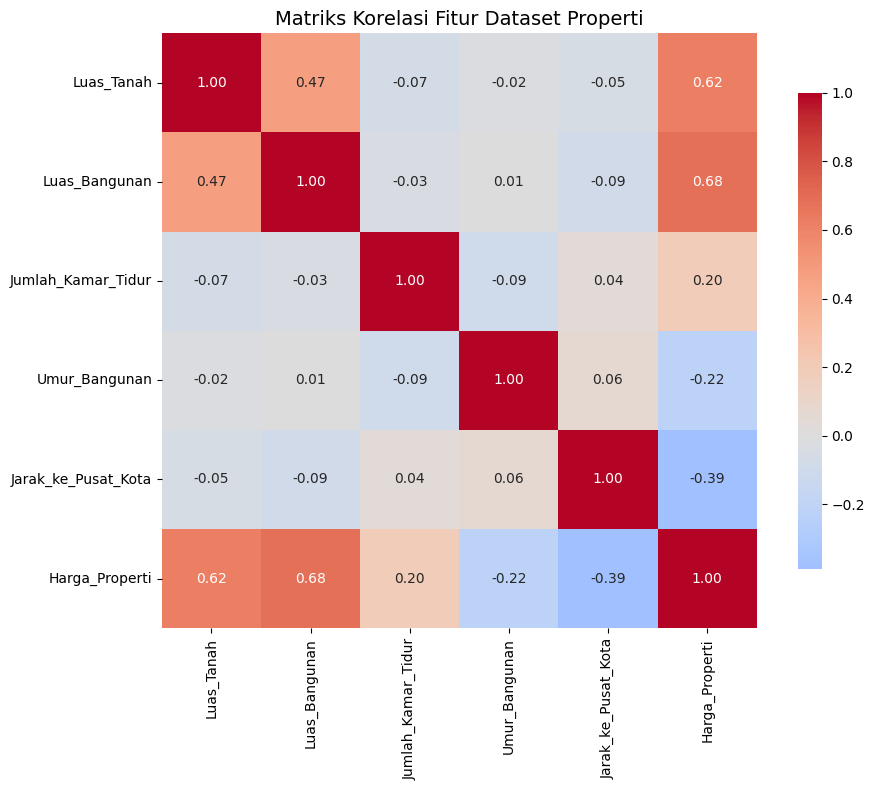

In [19]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Matriks Korelasi Fitur Dataset Properti', fontsize=14)
plt.tight_layout()
plt.show()

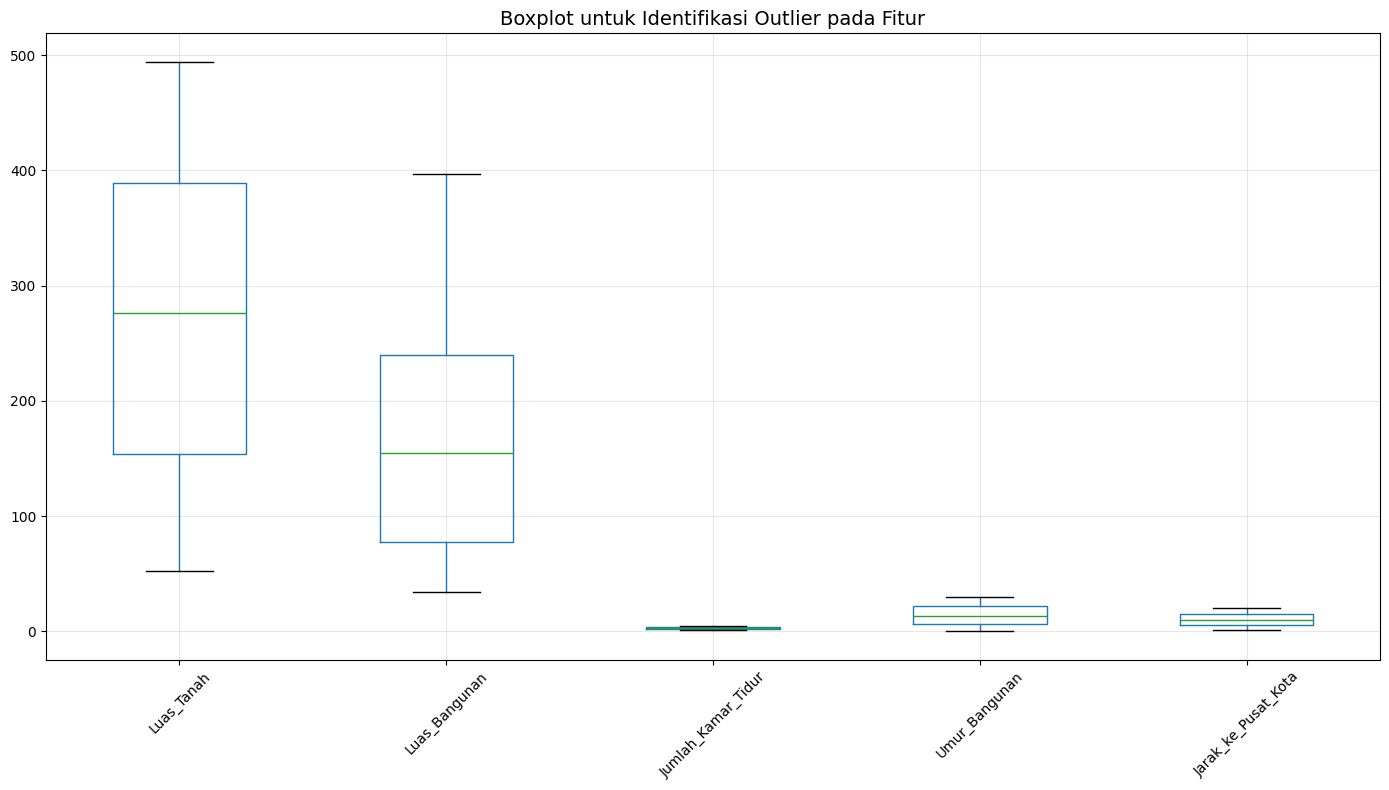

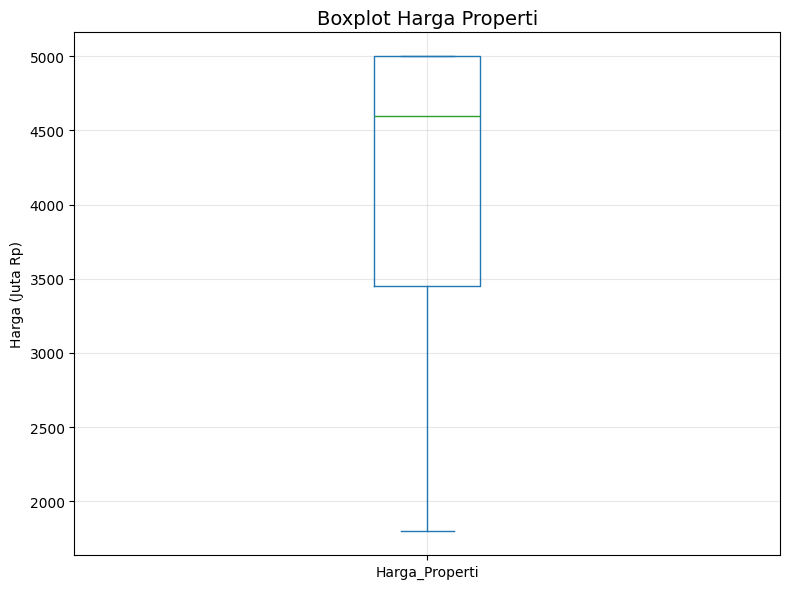

In [7]:
plt.figure(figsize=(14, 8))

# Plot untuk fitur kecuali harga
features_for_boxplot = ['Luas_Tanah', 'Luas_Bangunan', 'Jumlah_Kamar_Tidur', 
                       'Umur_Bangunan', 'Jarak_ke_Pusat_Kota']

df[features_for_boxplot].boxplot()
plt.title('Boxplot untuk Identifikasi Outlier pada Fitur', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot untuk harga terpisah
plt.figure(figsize=(8, 6))
df['Harga_Properti'].plot(kind='box')
plt.title('Boxplot Harga Properti', fontsize=14)
plt.ylabel('Harga (Juta Rp)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
def detect_outliers_iqr(data, feature_name):
    """Deteksi outliers menggunakan metode IQR"""
    Q1 = data[feature_name].quantile(0.25)
    Q3 = data[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[feature_name] < lower_bound) | (data[feature_name] > upper_bound)]
    outlier_percentage = (len(outliers) / len(data)) * 100
    
    return {
        'feature': feature_name,
        'outlier_count': len(outliers),
        'outlier_percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'min_value': data[feature_name].min(),
        'max_value': data[feature_name].max(),
        'outliers': outliers[feature_name].values
    }


In [9]:
outliers_analysis = []
all_features = ['Luas_Tanah', 'Luas_Bangunan', 'Jumlah_Kamar_Tidur', 
               'Umur_Bangunan', 'Jarak_ke_Pusat_Kota', 'Harga_Properti']

for feature in all_features:
    outlier_info = detect_outliers_iqr(df, feature)
    outliers_analysis.append(outlier_info)

# Tampilkan hasil analisis outliers
outliers_df = pd.DataFrame(outliers_analysis)
print("\nDetail Outliers untuk Setiap Fitur:")
print(outliers_df[['feature', 'outlier_count', 'outlier_percentage', 
                  'lower_bound', 'upper_bound']].round(2))



Detail Outliers untuk Setiap Fitur:
               feature  outlier_count  outlier_percentage  lower_bound  \
0           Luas_Tanah              0                 0.0      -198.70   
1        Luas_Bangunan              0                 0.0      -165.26   
2   Jumlah_Kamar_Tidur              0                 0.0        -1.00   
3        Umur_Bangunan              0                 0.0       -18.00   
4  Jarak_ke_Pusat_Kota              0                 0.0        -9.00   
5       Harga_Properti              0                 0.0      1124.34   

   upper_bound  
0       741.58  
1       482.31  
2         7.00  
3        46.00  
4        29.11  
5      7325.40  


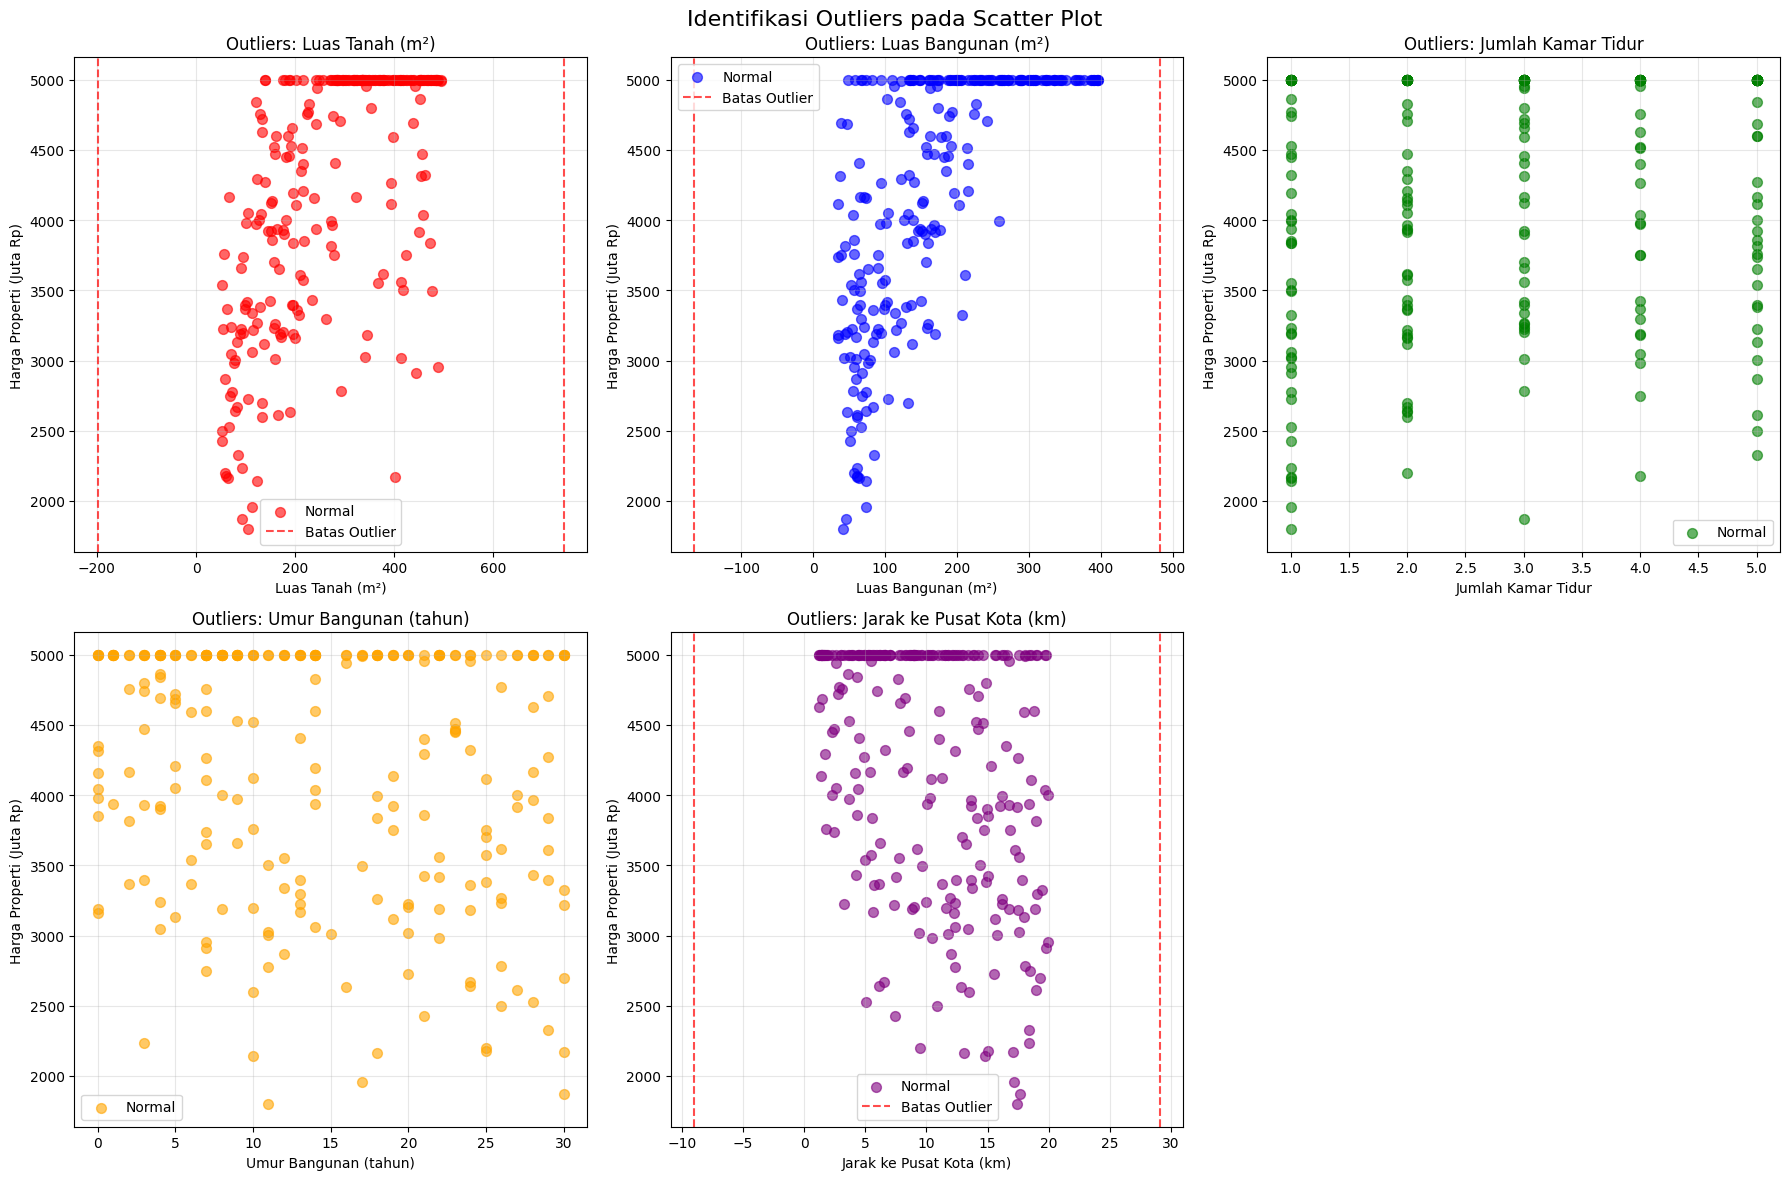


5d. SUMMARY OUTLIERS:
Total outliers terdeteksi: 0
Persentase outliers dari total data: 0.00%

Fitur dengan outliers terbanyak:
- Luas_Tanah: 0 outliers (0.0%)
- Luas_Bangunan: 0 outliers (0.0%)
- Jumlah_Kamar_Tidur: 0 outliers (0.0%)

✅ REKOMENDASI PENANGANAN OUTLIERS:
• Outliers sedikit (<5%), bisa dipertimbangkan untuk dihapus


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Identifikasi Outliers pada Scatter Plot', fontsize=16)

for i, (feature, title, color) in enumerate(zip(feature_names, feature_titles, colors)):
    ax = axes[i//3, i%3]
    
    # Deteksi outliers untuk fitur ini
    outlier_info = detect_outliers_iqr(df, feature)
    lower_bound = outlier_info['lower_bound']
    upper_bound = outlier_info['upper_bound']
    
    # Identifikasi points yang outliers
    is_outlier = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    
    # Plot normal points
    ax.scatter(df[~is_outlier][feature], df[~is_outlier]['Harga_Properti'],
              alpha=0.6, color=color, s=50, label='Normal')
    
    # Plot outlier points
    if is_outlier.any():
        ax.scatter(df[is_outlier][feature], df[is_outlier]['Harga_Properti'],
                  alpha=0.8, color='red', s=80, label='Outlier', marker='x')
    
    # Tambahkan batas outlier
    if feature not in ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']:
        ax.axvline(x=lower_bound, color='red', linestyle='--', alpha=0.7, label='Batas Outlier')
        ax.axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7)
    
    ax.set_title(f'Outliers: {title}', fontsize=12)
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Harga Properti (Juta Rp)', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last subplot
axes[1, 2].set_visible(False)
plt.tight_layout()
plt.show()

# 5d. Summary Outliers
print("\n5d. SUMMARY OUTLIERS:")
total_outliers = sum([info['outlier_count'] for info in outliers_analysis])
total_possible = len(df) * len(all_features)
outlier_percentage_total = (total_outliers / total_possible) * 100

print(f"Total outliers terdeteksi: {total_outliers}")
print(f"Persentase outliers dari total data: {outlier_percentage_total:.2f}%")

# Tampilkan fitur dengan outliers terbanyak
outliers_sorted = sorted(outliers_analysis, key=lambda x: x['outlier_count'], reverse=True)
print("\nFitur dengan outliers terbanyak:")
for info in outliers_sorted[:3]:
    print(f"- {info['feature']}: {info['outlier_count']} outliers ({info['outlier_percentage']:.1f}%)")

# Rekomendasi handling outliers
print("\n✅ REKOMENDASI PENANGANAN OUTLIERS:")
if outlier_percentage_total < 5:
    print("• Outliers sedikit (<5%), bisa dipertimbangkan untuk dihapus")
elif outlier_percentage_total < 15:
    print("• Outliers moderat (5-15%), pertimbangkan transformasi atau winsorizing")
else:
    print("• Outliers banyak (>15%), investigasi lebih lanjut sebelum penghapusan")


In [11]:
X = df.drop('Harga_Properti', axis=1)
y = df['Harga_Properti']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 175 samples
Testing set: 75 samples


In [12]:
int_columns = ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']
cont_columns = ['Luas_Tanah', 'Luas_Bangunan', 'Jarak_ke_Pusat_Kota']

scaler = StandardScaler()

# Scaling hanya untuk continuous features
X_train_cont_scaled = scaler.fit_transform(X_train[cont_columns])
X_test_cont_scaled = scaler.transform(X_test[cont_columns])

# Gabungkan kembali dengan integer features
X_train_scaled = pd.DataFrame(
    np.column_stack([X_train_cont_scaled, X_train[int_columns].values]),
    columns=cont_columns + int_columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    np.column_stack([X_test_cont_scaled, X_test[int_columns].values]),
    columns=cont_columns + int_columns,
    index=X_test.index
)

In [13]:
X_train_scaled.head()

,Luas_Tanah,Luas_Bangunan,Jarak_ke_Pusat_Kota,Jumlah_Kamar_Tidur,Umur_Bangunan
82,-0.525802,-1.341350,0.438695,2.0,0.0
29,-1.480367,-0.994794,0.014865,3.0,4.0
126,1.108966,1.652358,-0.175387,3.0,9.0
79,-1.247394,-0.690425,-0.452290,3.0,22.0
86,0.812230,1.690550,0.301186,3.0,14.0


In [21]:
# Pastikan folder Data Files dan Model Files sudah ada
data_dir = "../Data Files"
model_dir = "../Model Files"
os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

train_original = X_train.copy()
train_original['Harga_Properti'] = y_train.values

test_original = X_test.copy()
test_original['Harga_Properti'] = y_test.values

# Versi 2: Data SCALED - untuk training model
train_scaled = X_train_scaled.copy()
train_scaled['Harga_Properti'] = y_train.values

test_scaled = X_test_scaled.copy()
test_scaled['Harga_Properti'] = y_test.values

# Simpan semua versi
train_original.to_csv(os.path.join(data_dir, 'property_train_original.csv'), index=False)
test_original.to_csv(os.path.join(data_dir, 'property_test_original.csv'), index=False)
train_scaled.to_csv(os.path.join(data_dir, 'property_train_scaled.csv'), index=False)
test_scaled.to_csv(os.path.join(data_dir, 'property_test_scaled.csv'), index=False)
df.to_csv(os.path.join(data_dir, 'property_full_dataset.csv'), index=False)


# Save scaler

joblib.dump(scaler, os.path.join(model_dir, 'property_scaler.pkl'))


['../Model Files/property_scaler.pkl']

In [17]:
print(f"• Dataset: {len(df)} samples, {len(df.columns)} features")
print(f"• Korelasi tertinggi dengan harga: {df.corr()['Harga_Properti'].drop('Harga_Properti').abs().idxmax()}")
print(f"• Total outliers terdeteksi: {total_outliers} ({outlier_percentage_total:.1f}% dari total data)")
print(f"• Range harga: {df['Harga_Properti'].min():.2f} - {df['Harga_Properti'].max():.2f} juta Rp")

• Dataset: 250 samples, 6 features
• Korelasi tertinggi dengan harga: Luas_Bangunan
• Total outliers terdeteksi: 1 (0.1% dari total data)
• Range harga: 1158.66 - 5000.00 juta Rp
